In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.5 MB/s 
     |████████████████████████████████| 6.6 MB 46.6 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 733 kB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
import torch
import numpy as np
from torchtext.legacy import data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

## **1. Dataset Preparation**
The first column contains the sentiments and the last column contains the tweets.

In [ ]:
# Read in data into a dataframe

from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('pre_main_data.csv')

df.head(5)

Saving pre_main_data.csv to pre_main_data.csv


,id,label,tweet
0,0,2,! <user> as a woman you should not complain ab...
1,1,1,! <user> boy dats cold tyga dwn bad for cuffin...
2,2,1,! <user> dawg ! <user> you ever fuck a bitch a...
3,3,1,! <user> <user> she look like a tranny
4,4,1,! <user> the shit you hear about me might be t...


In [ ]:
del df["id"]
df

,label,tweet
0,2,! <user> as a woman you should not complain ab...
1,1,! <user> boy dats cold tyga dwn bad for cuffin...
2,1,! <user> dawg ! <user> you ever fuck a bitch a...
3,1,! <user> <user> she look like a tranny
4,1,! <user> the shit you hear about me might be t...
...,...,...
24428,1,you a muthaf***in <censored> lie “ <user> <use...
24429,2,you have gone and broke the wrong heart baby a...
24430,1,young buck wanna eat ! dat nigguh like i aint ...
24431,1,youu got wild bitches tellin you lies


In [ ]:
# Count the number of tweets per sentiment
df[0].value_counts()

4    800000
0    800000
Name: 0, dtype: int64

The dataset consists of two sentiments (0 - negative, 4 - positive)

In [ ]:
# Model the sentiments as binary (0 - negative, 1 - positive)
df[0]=df[0].replace(to_replace=4,value=1)
df[0].value_counts()

1    800000
0    800000
Name: 0, dtype: int64

In [ ]:
# Save a subset as a smaller dataset from training
df.sample(len(df)).to_csv("sentiment140-small.csv", header=None, index=None)

## **2. Preprocessing**

In [ ]:
TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
import torchtext

max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

# Map data to fields
fields = [('label', LABEL), ('tweet', TEXT)]

# Apply field definition to create torch dataset
dataset = torchtext.legacy.data.TabularDataset(
        path="sentiment140-small.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

# Split data into train, test, validation sets
(train_data, test_data, valid_data) = dataset.split(split_ratio=[0.8,0.1,0.1])

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))

Number of train data: 19546
Number of test data: 2444
Number of validation data: 2443


In [ ]:
# An example from the training set
print(vars(train_data.examples[0]))

{'label': '1', 'tweet': [1026, 5310, 1028, 1026, 5310, 1028, 2138, 7570, 2229, 14249, 3209, 2004, 2613, 2308]}


### **Build Vocabulary**

In [ ]:
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'1': 0, '2': 1, '0': 2})


In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False)


bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **3. Architecture**

In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

### **Create Model**

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

<a id='section4'></a>
# **4. Training**

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

# binary cross entropy
criterion = nn.BCEWithLogitsLoss()

# Use GPU
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Helper functions

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))

    # rounded_preds = torch.sigmoid(preds)
    # for i in range (len(rounded_preds)):
    #   if rounded_preds[i] <= 0.333:
    #     rounded_preds[i] = 0
    #   elif rounded_preds[i] > 0.333 and rounded_preds[i] <= 0.666:
    #     rounded_preds[i] = 2
    #   if rounded_preds[i] > 0.666 and rounded_preds[i] <= 1:
    #     rounded_preds[i] = 1 

    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from sklearn.metrics import confusion_matrix

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    count = 0
    confm = np.zeros((3,3))

    for batch in iterator:

        count += 1

        optimizer.zero_grad()
        
        predictions = model(batch.tweet).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        # print('Training Confusion Matrix')
        # rounded_preds = torch.sigmoid(predictions)
        # for i in range (len(rounded_preds)):
        #   if rounded_preds[i] <= 0.333:
        #     rounded_preds[i] = 0
        #   elif rounded_preds[i] > 0.333 and rounded_preds[i] <= 0.666:
        #     rounded_preds[i] = 2
        #   elif rounded_preds[i] > 0.666 and rounded_preds[i] <= 1:
        #     rounded_preds[i] = 1   
        # confm += confusion_matrix(rounded_preds.cpu().detach().numpy(), batch.label.cpu().detach().numpy())

    # print(confm)

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():

        count = 0
        conf = np.zeros((3,3))

        for batch in iterator:

            count += 1

            predictions = model(batch.tweet).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
            # print('Training Confusion Matrix')
            # rounded_preds = torch.sigmoid(predictions)
            # for i in range (len(rounded_preds)):
            #   if rounded_preds[i] <= 0.333:
            #     rounded_preds[i] = 0
            #   elif rounded_preds[i] > 0.333 and rounded_preds[i] <= 0.666:
            #     rounded_preds[i] = 2
            #   elif rounded_preds[i] > 0.666 and rounded_preds[i] <= 1:
            #     rounded_preds[i] = 1   
            # conf += confusion_matrix(rounded_preds.cpu().detach().numpy(), batch.label.cpu().detach().numpy())

    # print(conf)

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### **GRU Training**

Epoch: 01 | Epoch Time: 1m 32s
	Train Loss: -0.019 | Train Acc: 85.27%
	 Val. Loss: 0.023 |  Val. Acc: 84.65%
Epoch: 02 | Epoch Time: 1m 31s
	Train Loss: -0.132 | Train Acc: 85.87%
	 Val. Loss: 0.064 |  Val. Acc: 84.18%
Epoch: 03 | Epoch Time: 1m 31s
	Train Loss: -0.360 | Train Acc: 85.09%
	 Val. Loss: -0.195 |  Val. Acc: 85.86%
Epoch: 04 | Epoch Time: 1m 31s
	Train Loss: -0.463 | Train Acc: 84.78%
	 Val. Loss: -0.437 |  Val. Acc: 86.06%
Epoch: 05 | Epoch Time: 1m 32s
	Train Loss: -0.822 | Train Acc: 84.71%
	 Val. Loss: -0.489 |  Val. Acc: 85.36%
Epoch: 06 | Epoch Time: 1m 32s
	Train Loss: -1.228 | Train Acc: 84.75%
	 Val. Loss: -0.688 |  Val. Acc: 85.86%
Epoch: 07 | Epoch Time: 1m 32s
	Train Loss: -1.411 | Train Acc: 84.31%
	 Val. Loss: -0.939 |  Val. Acc: 84.65%
Epoch: 08 | Epoch Time: 1m 32s
	Train Loss: -1.932 | Train Acc: 83.99%
	 Val. Loss: -1.009 |  Val. Acc: 85.20%
Epoch: 09 | Epoch Time: 1m 32s
	Train Loss: -2.154 | Train Acc: 83.76%
	 Val. Loss: -0.774 |  Val. Acc: 84.26%
Epo

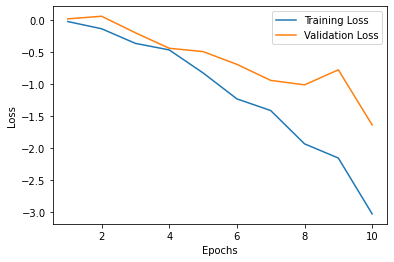

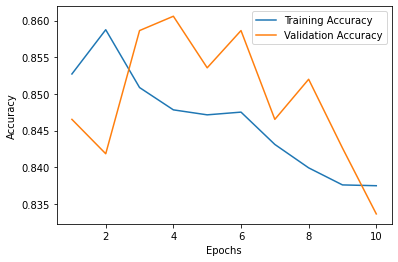

In [ ]:
N_EPOCHS = 10

loss_train = []
loss_valid = []
acc_train = []
acc_valid = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-bert.pt')
    
    loss_train.append(train_loss)
    loss_valid.append(valid_loss)
    acc_train.append(train_acc)
    acc_valid.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.linspace(1,N_EPOCHS,N_EPOCHS), loss_train, label='Training Loss') 
plt.plot(np.linspace(1,N_EPOCHS,N_EPOCHS), loss_valid, label='Validation Loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()   

plt.figure()
plt.plot(np.linspace(1,N_EPOCHS,N_EPOCHS), acc_train, label='Training Accuracy') 
plt.plot(np.linspace(1,N_EPOCHS,N_EPOCHS), acc_valid, label='Validation Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()  

## **5. Test**

In [ ]:
model.load_state_dict(torch.load('model-bert.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: -0.324 | Test Acc: 83.89%
